## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Split Dataset

In [2]:
# Load CSV
df = pd.read_csv('dataset_info.csv')
print(f"Total samples in dataset: {len(df)}")
print(f"\nClass distribution:")
print(df['class_name'].value_counts())

# Display first few rows
df.head()

Total samples in dataset: 6000

Class distribution:
class_name
Bacterial Leaf Spot    1200
Downy Mildew           1200
Healthy Leaf           1200
Mosaic Disease         1200
Powdery_Mildew         1200
Name: count, dtype: int64


filename             original_filename  \
0   Bacterial Leaf Spot (1)_orig.jpg   Bacterial Leaf Spot (1).jpg   
1   Bacterial Leaf Spot (1)_aug1.jpg   Bacterial Leaf Spot (1).jpg   
2   Bacterial Leaf Spot (1)_aug2.jpg   Bacterial Leaf Spot (1).jpg   
3  Bacterial Leaf Spot (10)_orig.jpg  Bacterial Leaf Spot (10).jpg   
4  Bacterial Leaf Spot (10)_aug1.jpg  Bacterial Leaf Spot (10).jpg   

            class_name  class_label  original_width  original_height  \
0  Bacterial Leaf Spot            0             800              599   
1  Bacterial Leaf Spot            0             800              599   
2  Bacterial Leaf Spot            0             800              599   
3  Bacterial Leaf Spot            0             800              599   
4  Bacterial Leaf Spot            0             800              599   

   resized_width  resized_height augmentation_type  \
0            224             224          original   
1            224             224       augmented_1   
2            224             224       augmented_2   
3            224             224          original   
4            224             224       augmented_1   

                                       relative_path  \
0  Bacterial Leaf Spot\Bacterial Leaf Spot (1)_or...   
1  Bacterial Leaf Spot\Bacterial Leaf Spot (1)_au...   
2  Bacterial Leaf Spot\Bacterial Leaf Spot (1)_au...   
3  Bacterial Leaf Spot\Bacterial Leaf Spot (10)_o...   
4  Bacterial Leaf Spot\Bacterial Leaf Spot (10)_a...   

                                 original_image_path  
0  Dataset\Bacterial Leaf Spot\Bacterial Leaf Spo...  
1  Dataset\Bacterial Leaf Spot\Bacterial Leaf Spo...  
2  Dataset\Bacterial Leaf Spot\Bacterial Leaf Spo...  
3  Dataset\Bacterial Leaf Spot\Bacterial Leaf Spo...  
4  Dataset\Bacterial Leaf Spot\Bacterial Leaf Spo...

In [3]:
# Split dataset: 70% train, 15% validation, 15% test
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (for val+test)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['class_label'],
    random_state=42
)

# Second split: Split temp into 50% val, 50% test (which is 15% each of total)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['class_label'],
    random_state=42
)

print(f"Train set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Train set size: 4200 (70.0%)
Validation set size: 900 (15.0%)
Test set size: 900 (15.0%)


## 3. Create Dataset and DataLoader

In [4]:
class LeafDiseaseDataset(Dataset):
    """Custom Dataset for loading resized leaf images"""
    
    def __init__(self, dataframe, root_dir='Dataset_Resized', transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image path and label
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'relative_path'])
        label = self.df.loc[idx, 'class_label']
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = LeafDiseaseDataset(train_df, transform=train_transform)
val_dataset = LeafDiseaseDataset(val_df, transform=val_test_transform)
test_dataset = LeafDiseaseDataset(test_df, transform=val_test_transform)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 132
Validation batches: 29
Test batches: 29


## 4. Define AlexNet Simplified Model

In [5]:
class AlexNet_simplified(nn.Module):
    def __init__(self, num_classes=5, exit_threshold=0.90):
        super(AlexNet_simplified, self).__init__()
        self.exit_threshold = exit_threshold

        # Conv Layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        # Conv Layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.exit1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

        # Conv Layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        self.exit2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(384, num_classes)
        )

        # Conv Layer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        self.exit3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(384, num_classes)
        )

        # Conv Layer 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Final Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x, inference=False):
        x = self.conv1(x)
        x = self.conv2(x)
        out1 = self.exit1(x)

        x = self.conv3(x)
        out2 = self.exit2(x)

        x = self.conv4(x)
        out3 = self.exit3(x)

        x = self.conv5(x)
        x = self.avgpool(x)
        out_final = self.classifier(x)

        if inference:
            conf1 = F.softmax(out1, dim=1).max(1).values
            if conf1.item() >= self.exit_threshold:
                return out1, "Exit1"

            conf2 = F.softmax(out2, dim=1).max(1).values
            if conf2.item() >= self.exit_threshold:
                return out2, "Exit2"

            conf3 = F.softmax(out3, dim=1).max(1).values
            if conf3.item() >= self.exit_threshold:
                return out3, "Exit3"

            return out_final, "Final"

        # During training, return all outputs
        return out1, out2, out3, out_final

# Initialize model
model = AlexNet_simplified(num_classes=5, exit_threshold=0.90).to(device)
print("Model initialized successfully!")
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

Model initialized successfully!

Model parameters: 58,309,716


## 5. Training Setup

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training parameters
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 7

print(f"Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: 0.001")
print(f"  Early stopping patience: {EARLY_STOP_PATIENCE}")

Training configuration:
  Epochs: 30
  Batch size: 32
  Learning rate: 0.001
  Early stopping patience: 7


## 6. Train Model

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass - get all exit outputs
        out1, out2, out3, out_final = model(images, inference=False)
        
        # Compute loss for all exits (weighted)
        loss1 = criterion(out1, labels)
        loss2 = criterion(out2, labels)
        loss3 = criterion(out3, labels)
        loss_final = criterion(out_final, labels)
        
        # Combined loss (you can adjust weights)
        loss = 0.1 * loss1 + 0.2 * loss2 + 0.3 * loss3 + 0.4 * loss_final
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy using final output
        _, predicted = torch.max(out_final.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            out1, out2, out3, out_final = model(images, inference=False)
            
            # Use final output for validation
            loss = criterion(out_final, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(out_final.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [8]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_loss = float('inf')
early_stop_counter = 0

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("✓ Model saved!")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{EARLY_STOP_PATIENCE}")
        
    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "="*50)
print("Training completed!")
print("="*50)

Starting training...


Epoch 1/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]



Train Loss: 1.4062 | Train Acc: 46.76%
Val Loss: 0.9576 | Val Acc: 59.22%
✓ Model saved!

Epoch 2/30
--------------------------------------------------
✓ Model saved!

Epoch 2/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 11.32it/s]



Train Loss: 0.8833 | Train Acc: 62.29%
Val Loss: 1.1107 | Val Acc: 62.22%
Early stopping counter: 1/7

Epoch 3/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.16it/s]



Train Loss: 0.8437 | Train Acc: 64.83%
Val Loss: 0.8054 | Val Acc: 69.78%
✓ Model saved!

Epoch 4/30
--------------------------------------------------
✓ Model saved!

Epoch 4/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.31it/s]



Train Loss: 0.7576 | Train Acc: 69.21%
Val Loss: 0.7716 | Val Acc: 71.44%
✓ Model saved!

Epoch 5/30
--------------------------------------------------
✓ Model saved!

Epoch 5/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00,  9.88it/s]



Train Loss: 0.7254 | Train Acc: 71.24%
Val Loss: 0.9650 | Val Acc: 64.11%
Early stopping counter: 1/7

Epoch 6/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 11.44it/s]



Train Loss: 0.6792 | Train Acc: 73.05%
Val Loss: 0.7130 | Val Acc: 72.22%
✓ Model saved!

Epoch 7/30
--------------------------------------------------
✓ Model saved!

Epoch 7/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.78it/s]



Train Loss: 0.6510 | Train Acc: 75.00%
Val Loss: 0.6448 | Val Acc: 75.67%
✓ Model saved!

Epoch 8/30
--------------------------------------------------
✓ Model saved!

Epoch 8/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:03<00:00,  9.47it/s]


Train Loss: 0.6307 | Train Acc: 75.52%
Val Loss: 0.7732 | Val Acc: 72.22%
Early stopping counter: 1/7

Epoch 9/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 11.00it/s]


Train Loss: 0.6198 | Train Acc: 77.07%
Val Loss: 0.7518 | Val Acc: 71.67%
Early stopping counter: 2/7

Epoch 10/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.09it/s]



Train Loss: 0.5635 | Train Acc: 79.07%
Val Loss: 0.8767 | Val Acc: 71.56%
Early stopping counter: 3/7

Epoch 11/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.08it/s]



Train Loss: 0.5518 | Train Acc: 80.33%
Val Loss: 0.6534 | Val Acc: 76.11%
Early stopping counter: 4/7

Epoch 12/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.52it/s]



Train Loss: 0.5008 | Train Acc: 82.33%
Val Loss: 0.5714 | Val Acc: 78.00%
✓ Model saved!

Epoch 13/30
--------------------------------------------------
✓ Model saved!

Epoch 13/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.50it/s]



Train Loss: 0.4735 | Train Acc: 82.74%
Val Loss: 0.5538 | Val Acc: 82.00%
✓ Model saved!

Epoch 14/30
--------------------------------------------------
✓ Model saved!

Epoch 14/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.68it/s]



Train Loss: 0.4644 | Train Acc: 83.88%
Val Loss: 0.4927 | Val Acc: 81.78%
✓ Model saved!

Epoch 15/30
--------------------------------------------------
✓ Model saved!

Epoch 15/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.08it/s]



Train Loss: 0.4416 | Train Acc: 84.79%
Val Loss: 0.6020 | Val Acc: 76.44%
Early stopping counter: 1/7

Epoch 16/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:03<00:00,  9.64it/s]



Train Loss: 0.4381 | Train Acc: 86.33%
Val Loss: 0.5187 | Val Acc: 80.56%
Early stopping counter: 2/7

Epoch 17/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.48it/s]


Train Loss: 0.4402 | Train Acc: 85.19%
Val Loss: 0.5839 | Val Acc: 75.44%
Early stopping counter: 3/7

Epoch 18/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.79it/s]



Train Loss: 0.4234 | Train Acc: 86.33%
Val Loss: 0.4702 | Val Acc: 83.67%
✓ Model saved!

Epoch 19/30
--------------------------------------------------
✓ Model saved!

Epoch 19/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.62it/s]


Train Loss: 0.4023 | Train Acc: 86.79%
Val Loss: 0.5133 | Val Acc: 81.78%
Early stopping counter: 1/7

Epoch 20/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00,  9.72it/s]



Train Loss: 0.3959 | Train Acc: 86.79%
Val Loss: 0.5094 | Val Acc: 80.33%
Early stopping counter: 2/7

Epoch 21/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.29it/s]


Train Loss: 0.3812 | Train Acc: 87.74%
Val Loss: 0.5137 | Val Acc: 79.11%
Early stopping counter: 3/7

Epoch 22/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.33it/s]


Train Loss: 0.3816 | Train Acc: 88.10%
Val Loss: 0.5942 | Val Acc: 79.22%
Early stopping counter: 4/7

Epoch 23/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.92it/s]



Train Loss: 0.3309 | Train Acc: 90.38%
Val Loss: 0.4307 | Val Acc: 84.11%
✓ Model saved!

Epoch 24/30
--------------------------------------------------
✓ Model saved!

Epoch 24/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.07it/s]



Train Loss: 0.3077 | Train Acc: 91.79%
Val Loss: 0.4484 | Val Acc: 83.44%
Early stopping counter: 1/7

Epoch 25/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.19it/s]



Train Loss: 0.3050 | Train Acc: 91.33%
Val Loss: 0.4236 | Val Acc: 86.33%
✓ Model saved!

Epoch 26/30
--------------------------------------------------
✓ Model saved!

Epoch 26/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.29it/s]



Train Loss: 0.3041 | Train Acc: 92.14%
Val Loss: 0.4976 | Val Acc: 82.78%
Early stopping counter: 1/7

Epoch 27/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.84it/s]


Train Loss: 0.2893 | Train Acc: 92.48%
Val Loss: 0.5478 | Val Acc: 84.00%
Early stopping counter: 2/7

Epoch 28/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.00it/s]


Train Loss: 0.2691 | Train Acc: 93.45%
Val Loss: 0.4579 | Val Acc: 84.33%
Early stopping counter: 3/7

Epoch 29/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.30it/s]



Train Loss: 0.2865 | Train Acc: 93.21%
Val Loss: 0.5381 | Val Acc: 81.78%
Early stopping counter: 4/7

Epoch 30/30
--------------------------------------------------


Validating: 100%|██████████| 29/29 [00:02<00:00, 10.17it/s]



Train Loss: 0.2479 | Train Acc: 94.71%
Val Loss: 0.3905 | Val Acc: 86.89%
✓ Model saved!

Training completed!
✓ Model saved!

Training completed!


## 7. Plot Training History

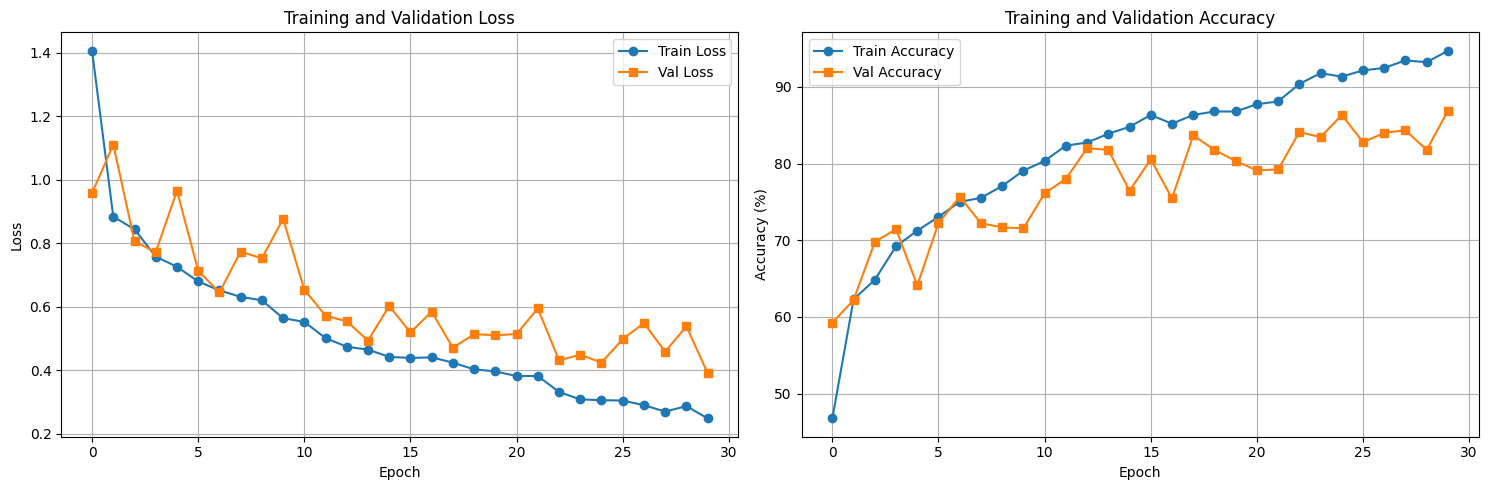

Best validation loss: 0.3905
Best validation accuracy: 86.89%


In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(val_accs, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {max(val_accs):.2f}%")

## 8. Test on Original Images (NOT from CSV)

Here we load the **original images** directly from the Dataset folder and test the model.

In [10]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("Best model loaded!")

Best model loaded!


In [11]:
def preprocess_original_image(image_path, img_size=224):
    """Preprocess original image for model prediction"""
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize to model input size
    img_resized = cv2.resize(img, (img_size, img_size))
    
    # Apply same transforms as validation
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(img_resized)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    
    return img_tensor, img

def predict_original_image(model, image_path, device):
    """Predict class for an original image"""
    img_tensor, original_img = preprocess_original_image(image_path)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        # Get prediction (using final output for testing)
        out1, out2, out3, out_final = model(img_tensor, inference=False)
        
        # Get prediction and confidence
        probabilities = F.softmax(out_final, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
    return predicted.item(), confidence.item(), probabilities.cpu().numpy()[0], original_img

In [12]:
# Get unique original images from test set (not augmented)
test_original_images = test_df[test_df['augmentation_type'] == 'original'].copy()
print(f"Testing on {len(test_original_images)} original images from test set\n")

# Class names
class_names = [
    "Bacterial Leaf Spot",
    "Downy Mildew",
    "Healthy Leaf",
    "Mosaic Disease",
    "Powdery Mildew"
]

# Test on original images
predictions = []
true_labels = []
confidences = []

print("Testing on original images...\n")

for idx, row in tqdm(test_original_images.iterrows(), total=len(test_original_images), desc="Testing"):
    original_path = row['original_image_path']
    true_label = row['class_label']
    
    # Predict
    pred_label, confidence, probs, _ = predict_original_image(model, original_path, device)
    
    predictions.append(pred_label)
    true_labels.append(true_label)
    confidences.append(confidence)

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predictions) * 100
avg_confidence = np.mean(confidences) * 100

print(f"\n{'='*60}")
print("TEST RESULTS ON ORIGINAL IMAGES")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Average Confidence: {avg_confidence:.2f}%")
print(f"{'='*60}\n")

Testing on 297 original images from test set

Testing on original images...



Testing: 100%|██████████| 297/297 [00:05<00:00, 57.63it/s]


TEST RESULTS ON ORIGINAL IMAGES
Test Accuracy: 88.55%
Average Confidence: 92.15%



## 9. Detailed Evaluation

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.75      0.85      0.80        61
       Downy Mildew       0.87      0.96      0.92        57
       Healthy Leaf       0.92      0.78      0.85        60
     Mosaic Disease       0.96      0.95      0.95        56
     Powdery Mildew       0.95      0.89      0.92        63

           accuracy                           0.89       297
          macro avg       0.89      0.89      0.89       297
       weighted avg       0.89      0.89      0.89       297



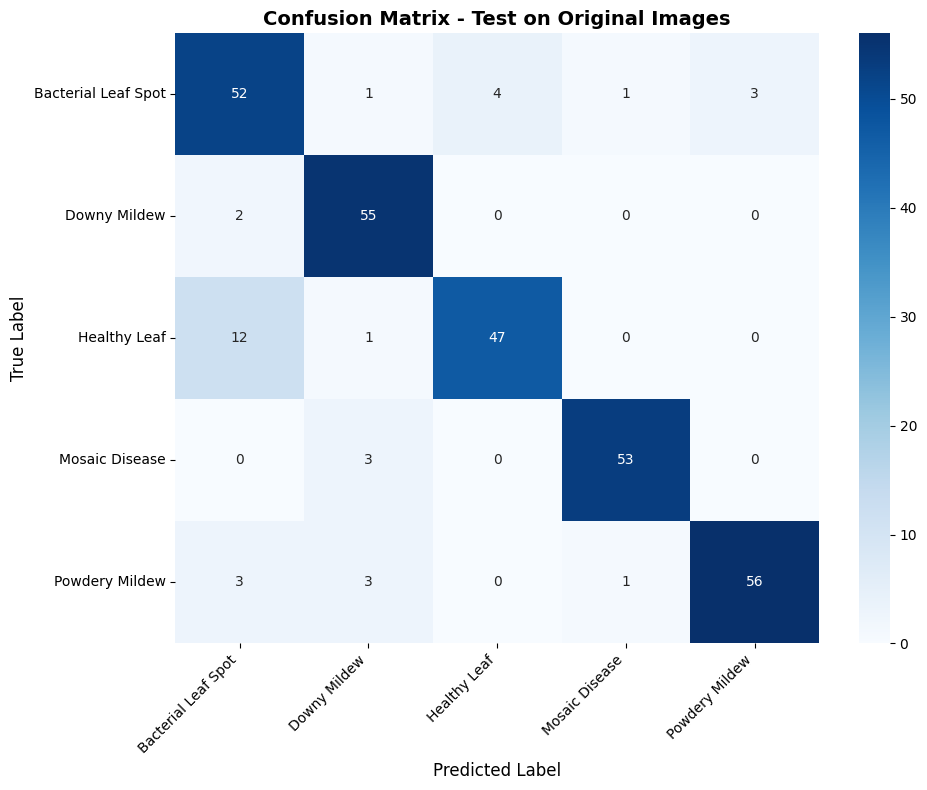

In [13]:
# Classification report
print("Classification Report:")
print("="*60)
print(classification_report(true_labels, predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix - Test on Original Images', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Visualize Sample Predictions

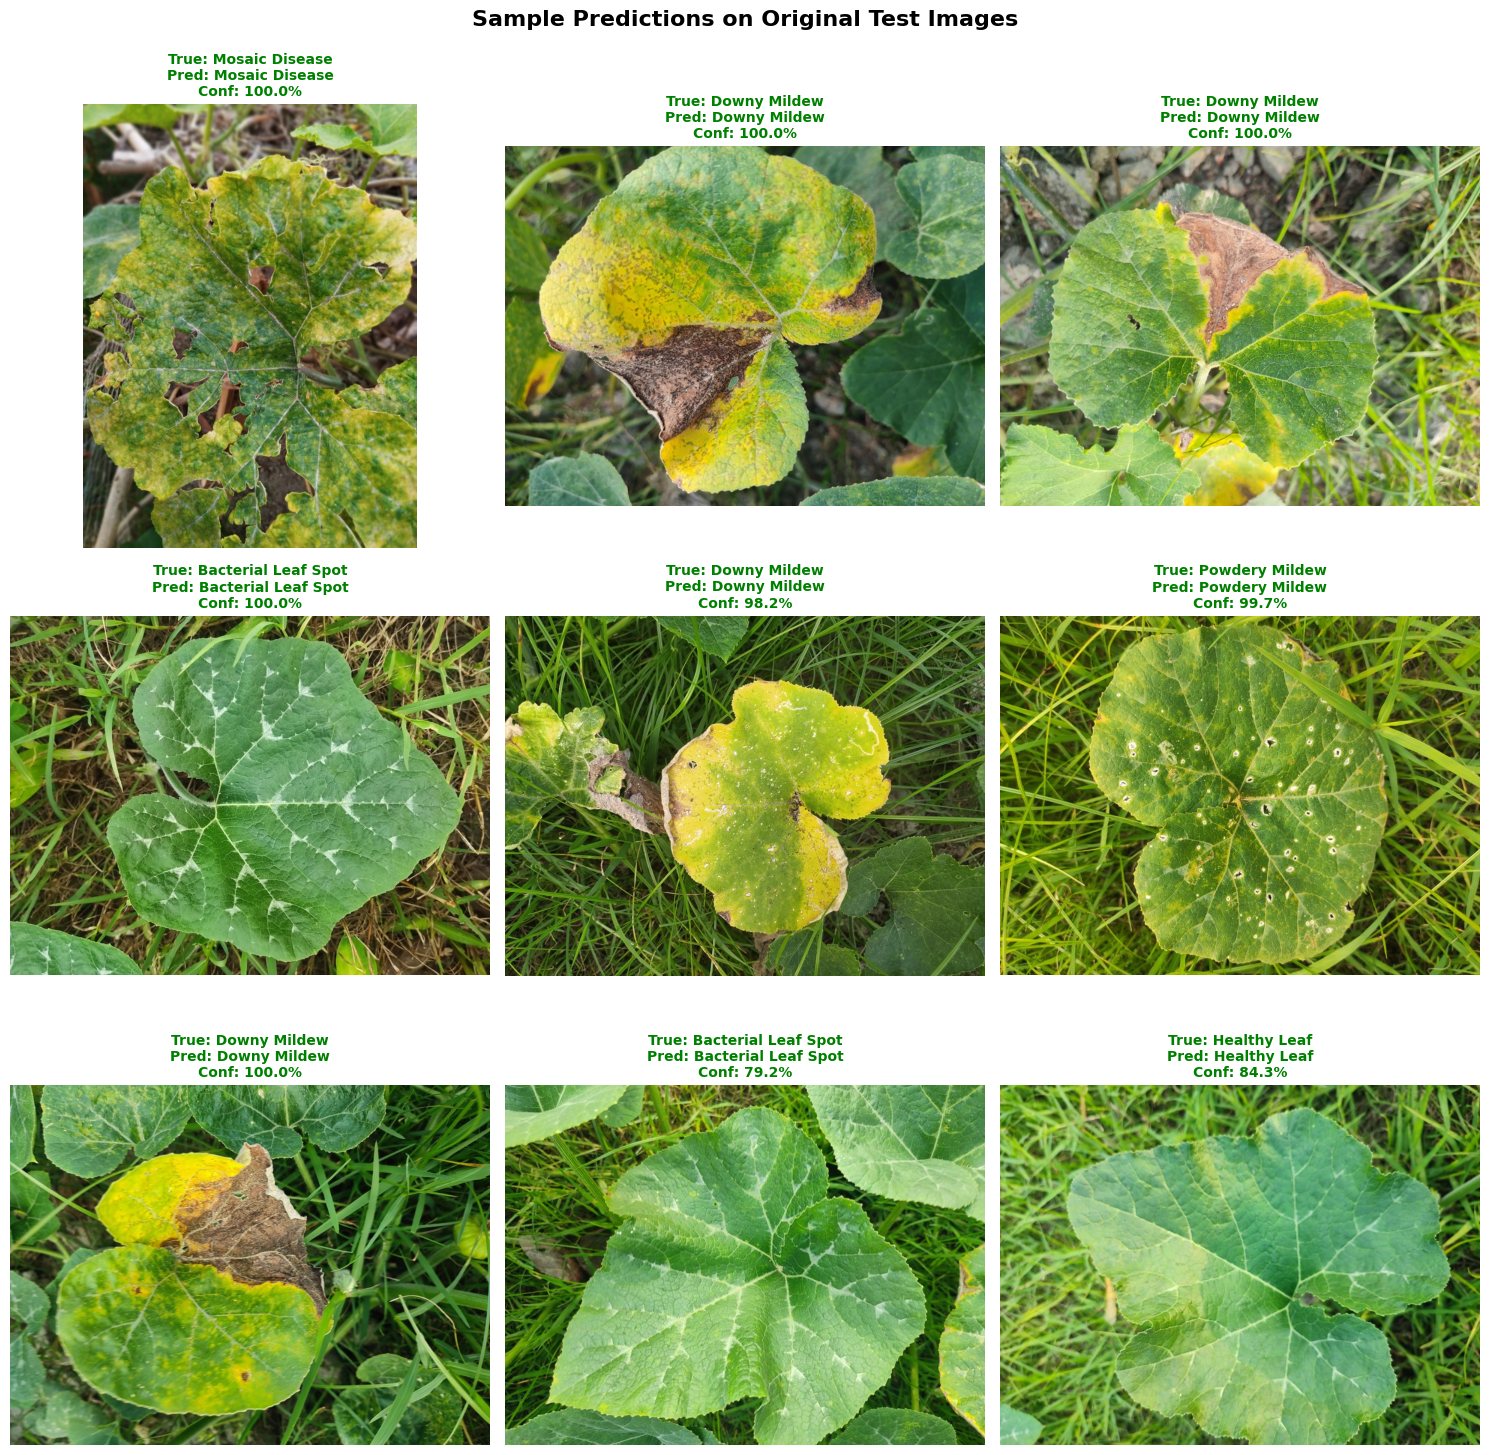

In [14]:
# Visualize some predictions
sample_indices = np.random.choice(len(test_original_images), size=min(9, len(test_original_images)), replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    row = test_original_images.iloc[idx]
    original_path = row['original_image_path']
    true_label = row['class_label']
    
    # Predict
    pred_label, confidence, probs, img = predict_original_image(model, original_path, device)
    
    # Plot
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Title with prediction
    color = 'green' if pred_label == true_label else 'red'
    title = f"True: {class_names[true_label]}\n"
    title += f"Pred: {class_names[pred_label]}\n"
    title += f"Conf: {confidence*100:.1f}%"
    axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')

plt.suptitle('Sample Predictions on Original Test Images', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Save Results

In [15]:
# Save test results to CSV
results_df = test_original_images.copy()
results_df['predicted_label'] = predictions
results_df['predicted_class'] = [class_names[p] for p in predictions]
results_df['confidence'] = confidences
results_df['correct'] = [p == t for p, t in zip(predictions, true_labels)]

results_df.to_csv('test_results.csv', index=False)
print("Test results saved to 'test_results.csv'")

# Display sample results
print("\nSample test results:")
results_df[['original_filename', 'class_name', 'predicted_class', 'confidence', 'correct']].head(10)

Test results saved to 'test_results.csv'

Sample test results:


original_filename           class_name      predicted_class  \
0       Mosaic Disease (225).jpg       Mosaic Disease       Mosaic Disease   
6       Powdery_Mildew (397).jpg       Powdery_Mildew       Mosaic Disease   
7           Healthy Leaf (8).jpg         Healthy Leaf         Healthy Leaf   
11        Downy Mildew (369).jpg         Downy Mildew         Downy Mildew   
14      Powdery_Mildew (131).jpg       Powdery_Mildew       Powdery Mildew   
16        Downy Mildew (358).jpg         Downy Mildew         Downy Mildew   
18        Healthy Leaf (193).jpg         Healthy Leaf         Healthy Leaf   
22      Mosaic Disease (311).jpg       Mosaic Disease       Mosaic Disease   
29  Bacterial Leaf Spot (68).jpg  Bacterial Leaf Spot  Bacterial Leaf Spot   
30        Healthy Leaf (263).jpg         Healthy Leaf         Healthy Leaf   

    confidence  correct  
0     0.999759     True  
6     0.999942    False  
7     0.892798     True  
11    0.530411     True  
14    0.999936     True  
16    0.982114     True  
18    0.985881     True  
22    0.858874     True  
29    0.722169     True  
30    0.843276     True

## 12. Model Summary

In [16]:
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model Architecture: AlexNet Simplified with Early Exits")
print(f"Number of Classes: {len(class_names)}")
print(f"Input Size: 224x224x3")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\nTraining Dataset Size: {len(train_df)}")
print(f"Validation Dataset Size: {len(val_df)}")
print(f"Test Dataset Size: {len(test_df)}")
print(f"\nBest Validation Accuracy: {max(val_accs):.2f}%")
print(f"Test Accuracy (Original Images): {test_accuracy:.2f}%")
print(f"Average Prediction Confidence: {avg_confidence:.2f}%")
print("="*60)

print("\nClass-wise Performance:")
for i, class_name in enumerate(class_names):
    class_mask = np.array(true_labels) == i
    class_acc = accuracy_score(
        np.array(true_labels)[class_mask], 
        np.array(predictions)[class_mask]
    ) * 100
    print(f"  {class_name}: {class_acc:.2f}%")

print("\nModel saved as: best_model.pth")
print("Results saved as: test_results.csv")
print("\n✓ Training and testing complete!")


FINAL MODEL SUMMARY
Model Architecture: AlexNet Simplified with Early Exits
Number of Classes: 5
Input Size: 224x224x3
Total Parameters: 58,309,716
Trainable Parameters: 58,309,716

Training Dataset Size: 4200
Validation Dataset Size: 900
Test Dataset Size: 900

Best Validation Accuracy: 86.89%
Test Accuracy (Original Images): 88.55%
Average Prediction Confidence: 92.15%

Class-wise Performance:
  Bacterial Leaf Spot: 85.25%
  Downy Mildew: 96.49%
  Healthy Leaf: 78.33%
  Mosaic Disease: 94.64%
  Powdery Mildew: 88.89%

Model saved as: best_model.pth
Results saved as: test_results.csv

✓ Training and testing complete!
